# Setup for GNN Training

In [1]:
# mount to Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# move to the working folder
FOLDERNAME = 'network_processing'
%cd drive/MyDrive/$FOLDERNAME/

/content/drive/MyDrive/network_processing


In [3]:
# install torch_geometric if necessary
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 60.1 MB/s eta 0:00:00


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
from torch.utils.data import TensorDataset, DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm import tqdm
import re
import random

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

import networkx as nx
import matplotlib.pyplot as plt

In [5]:
if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')
print('Device', device)

Device cuda


# Build GNN Model

In [6]:
# build the GAT model
class GAT(nn.Module):
    def __init__(self, input_dim, gat_hidden_dim, output_dim, num_gat_layers, num_heads):
        super(GAT, self).__init__()
        self.gat_layers = nn.ModuleList([
            GATConv(input_dim if i == 0 else gat_hidden_dim * num_heads, gat_hidden_dim, heads=num_heads, dropout=0.2)
            for i in range(num_gat_layers)
        ])
        self.predict = nn.Linear(gat_hidden_dim * num_heads, output_dim)
        self.edge_weight = None
        self.edge = None

    def forward(self, x, edge_index):
        self.edge = edge_index
        for gat in self.gat_layers:
            x, weight = gat(x, edge_index, return_attention_weights=True)
            self.edge_weight = weight[1]
            self.edge = weight[0]
            x = F.relu(x)
        x = self.predict(x)
        return x

    def get_edge_weight(self):
        return self.edge_weight

    def get_edge(self):
        return self.edge

# Training Data Preprocessing

In [393]:
# load the company relationship data
file_path = './Company_Relationship.xlsx'
data = pd.read_excel(file_path, sheet_name='Total_Network', header=None)

In [394]:
# process the company relationship data
edges = []
for i in range(data.shape[0]):
    for row_index, j in enumerate(data.iloc[i, 3:].dropna().to_list()):
        numbers = re.findall(r'-?\d+', j)
        if len(numbers) < 2:
            continue
        start, end = int(numbers[0]), int(numbers[1])
        edges.append((start, end))

edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

In [395]:
# load the output data from imaging processing and extract features
output_path = './ResNet_output_vectors_training.csv'
df_image = pd.read_csv(output_path)
df_image['date'] = pd.to_datetime(df_image['date'])
stocks = df_image['stock']
df_image = df_image.rename(columns={'vector': 'vector1'})
dates = df_image['date']
vectors = df_image['vector1'].apply(lambda x: np.fromstring(x.strip('[]'), sep=',')).tolist()

In [396]:
# load the output data from text processing and extract features
news_output_path = './multi_x_2014-2021_avg.csv'
df_news = pd.read_csv(news_output_path)
df_news['date'] = pd.to_datetime(df_news['date'])
df_news = df_news.rename(columns={'vector': 'vector2'})
merged_vector_df = pd.merge(df_image, df_news, left_on=['stock', 'date', 'label'], right_on=['stock', 'date', 'label'], how='inner')

In [397]:
# Load the macroeconomic data
macro_path = './normalized_macro.csv'
df_macro = pd.read_csv(macro_path)
df_macro['Date'] = pd.to_datetime(df_macro['Date'])
merged_df = pd.merge(merged_vector_df, df_macro, left_on='date', right_on='Date', how='inner')
merged_df = merged_df.drop(columns=['Date'])

# Extract combined vectors without titles
vectors_combined = []
for idx, row in merged_df.iterrows():
    resnet_vector = np.fromstring(row['vector1'].strip('[]'), sep=',')
    news_vector = np.fromstring(row['vector2'].strip('[]'), sep=',')
    macro_vector = row[['USD/TWD', 'VIX', ' Crude Oil', 'Gold', 'CPI', 'Unemployment Rate', 'Interest Rate', 'M2']].values.astype(float)
    combined_vector = np.concatenate([resnet_vector, news_vector, macro_vector])
    vectors_combined.append(combined_vector)
print(vectors_combined[0])

[-4.07785100e-01  1.97269840e-01 -7.47469370e-01  2.61349980e-01
  3.37564200e-01  5.35220400e-01  1.94265260e-01 -5.51022000e-02
 -4.61750570e-01 -1.34333950e-02  1.06015220e+01 -8.46786900e+00
 -1.51163300e+01  8.74160000e+00  2.93561480e+00 -7.39163200e+00
  1.28533780e-02 -1.51212400e+01 -5.63439200e+00 -1.05562960e+01
  1.30194843e-01  7.62713166e-02  9.77349862e-01  9.77349862e-01
  9.78380095e-01  0.00000000e+00  1.00000000e+00  1.00000000e+00]


In [398]:
# Create a DataFrame for the combined data
combined_df = pd.DataFrame({
    'stock': merged_df['stock'],
    'date': merged_df['date'],
    'vector': vectors_combined
})

# Convert vectors to the required string format
combined_df['vector'] = combined_df['vector'].apply(lambda x: ','.join(map(str, x)))

# Prepare the graph data
node_features = torch.tensor(vectors_combined, dtype=torch.float)
data = Data(x=node_features, edge_index=edge_index)

In [399]:
print(combined_df)

      stock       date                                             vector
0      2912 2017-02-10  -0.4077851,0.19726984,-0.74746937,0.26134998,0...
1      3008 2017-02-10  -1.0573753,-0.19213456,-0.75838864,0.26124352,...
2      3045 2017-02-10  -0.5620555,0.13207173,-1.0222733,0.24373452,0....
3      3481 2017-02-10  -0.43872702,-0.027354524,-0.33911988,0.0909796...
4      3711 2017-02-10  -0.76355135,-0.0056462884,-0.5489043,0.1419947...
...     ...        ...                                                ...
7504   1101 2017-01-17  -0.5869068,0.4982531,-1.5782189,0.827671,0.922...
7505   1102 2017-01-17  -0.38182026,0.39802492,-1.7586601,0.81011724,1...
7506   1216 2017-01-17  -0.8911615,0.14955604,-0.95882356,0.28993598,-...
7507   1301 2017-01-17  -0.87212074,0.3000575,-1.109202,0.48879683,0.3...
7508   1303 2017-01-17  -0.42662844,0.20647326,-0.63008034,0.44265088,...

[7509 rows x 3 columns]


# Testing Data Preprocessing

In [400]:
# load the output data from imaging processing and extract features
t_output_path = './ResNet_output_vectors_testing.csv'
t_df_image = pd.read_csv(t_output_path)
t_df_image['date'] = pd.to_datetime(t_df_image['date'])
t_stocks = t_df_image['stock']
t_df_image = t_df_image.rename(columns={'vector': 'vector1'})
t_dates = t_df_image['date']
t_vectors = t_df_image['vector1'].apply(lambda x: np.fromstring(x.strip('[]'), sep=',')).tolist()

In [401]:
# load the output data from text processing and extract features
t_news_output_path = './multi_x_2022-2024_avg.csv'
t_df_news = pd.read_csv(t_news_output_path)
t_df_news['date'] = pd.to_datetime(t_df_news['date'])
t_df_news = t_df_news.rename(columns={'vector': 'vector2'})
t_merged_vector_df = pd.merge(t_df_image, t_df_news, left_on=['stock', 'date', 'label'], right_on=['stock', 'date', 'label'], how='inner')

In [402]:
# Load the macroeconomic data
t_macro_path = './normalized_macro.csv'
t_df_macro = pd.read_csv(t_macro_path)
t_df_macro['Date'] = pd.to_datetime(t_df_macro['Date'])
t_merged_df = pd.merge(t_merged_vector_df, t_df_macro, left_on='date', right_on='Date', how='inner')
t_merged_df = t_merged_df.drop(columns=['Date'])

# Extract combined vectors without titles
t_vectors_combined = []
for idx, row in t_merged_df.iterrows():
    t_resnet_vector = np.fromstring(row['vector1'].strip('[]'), sep=',')
    t_news_vector = np.fromstring(row['vector2'].strip('[]'), sep=',')
    t_macro_vector = row[['USD/TWD', 'VIX', ' Crude Oil', 'Gold', 'CPI', 'Unemployment Rate', 'Interest Rate', 'M2']].values.astype(float)
    t_combined_vector = np.concatenate([t_resnet_vector, t_news_vector, t_macro_vector])
    t_vectors_combined.append(t_combined_vector)
print(t_vectors_combined[0])

[ -0.793993     0.045899    -0.5591482    0.10350668   0.04407129
   0.61192286   0.33957642  -0.05961948  -0.08431272   0.19534688
  12.443968    -2.688599   -14.328994    14.984826     3.5409274
  -0.6059257   -8.749729   -14.468763    -3.9812279  -13.562073
   0.29412089   0.2725015    0.66352214   0.66352214   1.
   0.1          0.           1.        ]


In [403]:
# Create a DataFrame for the combined data
t_combined_df = pd.DataFrame({
    'stock': t_merged_df['stock'],
    'date': t_merged_df['date'],
    'vector': t_vectors_combined
})

# Convert vectors to the required string format
t_combined_df['vector'] = t_combined_df['vector'].apply(lambda x: ','.join(map(str, x)))

# Prepare the graph data
t_node_features = torch.tensor(t_vectors_combined, dtype=torch.float)
t_data = Data(x=t_node_features, edge_index=edge_index)

In [404]:
print(t_combined_df)

      stock       date                                             vector
0      2615 2022-01-10  -0.793993,0.045899004,-0.5591482,0.103506684,0...
1      2801 2022-01-10  -0.6627596,0.18887809,-1.383009,0.48637658,0.8...
2      2880 2022-01-10  -0.52059186,0.03306061,-0.5854644,0.31243658,0...
3      2881 2022-01-10  -1.2498739,0.9513232,-3.0062773,1.1086042,0.98...
4      2882 2022-01-10  -0.42998013,0.020922571,-0.3883301,0.15152282,...
...     ...        ...                                                ...
2345   1216 2024-06-18  -0.61969745,0.15058833,-1.2258343,0.62946,0.62...
2346   1301 2024-06-18  -0.4183076,0.2094575,-0.9131763,0.5601954,0.95...
2347   1303 2024-06-18  -0.44064954,0.011254355,-0.26940867,0.1229532,...
2348   1326 2024-06-18  -0.60400164,0.16928256,-1.1311513,0.50317544,0...
2349   1402 2024-06-18  -0.41709688,0.12631299,-0.51364434,0.35680038,...

[2350 rows x 3 columns]


# Training

In [405]:
# initialize the GAT model
input_dim = node_features.size(1)
gat_hidden_dim = 10
output_dim = 1
num_gat_layers = 2
num_heads = 2
model = GAT(input_dim, gat_hidden_dim, output_dim, num_gat_layers, num_heads)

In [406]:
# move data and model to device
data = data.to(device)
model = model.to(device)

In [407]:
# constants for model training
NUM_EPOCHS = 200
PRINT_EVERY = 10

In [408]:
# define loss and optimizer
loss_function = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [409]:
# label for testing accuracy
# label = torch.randint(0, 2, (node_features.size(0),), dtype=torch.float).unsqueeze(1)  # dummy labels for test
label = torch.tensor(merged_df['label']).float().unsqueeze(1)
print(label.shape)

torch.Size([7509, 1])


In [410]:
# Move data to the appropriate device
data.x = data.x.to(device)
data.edge_index = data.edge_index.to(device)
label = label.to(device)
model = model.to(device)

In [411]:
# training loop
model.train()
for epoch in range(NUM_EPOCHS):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = loss_function(out, label)
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        predictions = torch.sigmoid(out)
        predicted_labels = (predictions > 0.5).float()
        correct = (predicted_labels == label).sum().item()
        total = label.size(0)
        accuracy = correct / total

    if (epoch + 1) % PRINT_EVERY == 0:
        print(f'Epoch {epoch + 1}/{NUM_EPOCHS}, Loss: {loss.item()}, Training Accuracy: {accuracy * 100:.2f}%')

print('Training completed.')

Epoch 10/200, Loss: 0.4189789295196533, Training Accuracy: 82.62%
Epoch 20/200, Loss: 0.3306576907634735, Training Accuracy: 84.37%
Epoch 30/200, Loss: 0.299558162689209, Training Accuracy: 85.22%
Epoch 40/200, Loss: 0.28337597846984863, Training Accuracy: 85.88%
Epoch 50/200, Loss: 0.25877124071121216, Training Accuracy: 86.98%
Epoch 60/200, Loss: 0.233450248837471, Training Accuracy: 88.47%
Epoch 70/200, Loss: 0.20290498435497284, Training Accuracy: 90.11%
Epoch 80/200, Loss: 0.18668945133686066, Training Accuracy: 90.53%
Epoch 90/200, Loss: 0.1697460561990738, Training Accuracy: 91.69%
Epoch 100/200, Loss: 0.1644088327884674, Training Accuracy: 92.17%
Epoch 110/200, Loss: 0.15505185723304749, Training Accuracy: 92.77%
Epoch 120/200, Loss: 0.15578222274780273, Training Accuracy: 92.80%
Epoch 130/200, Loss: 0.1458902657032013, Training Accuracy: 92.94%
Epoch 140/200, Loss: 0.15173056721687317, Training Accuracy: 92.40%
Epoch 150/200, Loss: 0.14707595109939575, Training Accuracy: 92.73

In [412]:
# Inference to obtain final vectors
model.eval()
with torch.no_grad():
    final_vectors = model(data.x, data.edge_index)

# Convert predictions to a single vector per stock
final_vectors = final_vectors.squeeze().cpu().numpy()

# Adjust the length of stocks and dates to match final_vectors
original_length = len(final_vectors)

# Filter stocks and dates to match the number of final_vectors
stocks_filtered = stocks[:original_length]
dates_filtered = dates[:original_length]

# prepare the output data for CSV
output_data = {
    "stock": stocks_filtered,
    "date": dates_filtered,
    "vector": final_vectors
}

output_df = pd.DataFrame(output_data)
output_df.sort_values(by=['stock', 'date'])
print(output_df)
output_df.to_csv('ResNet_Total_output_vectors_training.csv', index=True)

      stock       date     vector
0      2912 2017-02-10  -5.782745
1      2912 2017-03-02  -6.876583
2      2912 2017-03-20  -0.078595
3      2912 2017-04-07   2.593596
4      2912 2017-04-25   1.597746
...     ...        ...        ...
7504   1301 2014-10-02   4.925572
7505   1301 2014-10-21  15.876584
7506   1301 2014-11-06  -4.521917
7507   1301 2014-11-24   4.930777
7508   1301 2014-12-10  11.825694

[7509 rows x 3 columns]


# Testing

In [413]:
# label for testing accuracy
t_label = torch.tensor(t_merged_df['label']).float().unsqueeze(1)
print(t_label.shape)

torch.Size([2350, 1])


In [414]:
# Move data to the appropriate device
t_data.x = t_data.x.to(device)
t_data.edge_index = t_data.edge_index.to(device)
t_label = t_label.to(device)

In [415]:
# Inference to obtain final vectors
model.eval()
with torch.no_grad():
    test_output = model(t_data.x, t_data.edge_index)

# Convert the model outputs to probabilities
test_predictions = torch.sigmoid(test_output)

# Convert probabilities to binary labels
predicted_labels = (test_predictions > 0.5).float()

# Calculate accuracy
correct = (predicted_labels == t_label).sum().item()
total = t_label.size(0)
accuracy = (correct / total) * 100
print(f'Test Accuracy: {accuracy:.2f}%')

Test Accuracy: 52.04%


In [416]:
# Convert predictions to a single vector per stock
t_final_vectors = test_output.squeeze().cpu().numpy()

# prepare the output data for CSV
t_output_data = {
    "stock": t_stocks,
    "date": t_dates,
    "vector": t_final_vectors
}

t_output_df = pd.DataFrame(t_output_data)
t_output_df.sort_values(by=['stock', 'date'])
print(t_output_df)
t_output_df.to_csv('ResNet_Total_output_vectors_testing.csv', index=True)

      stock       date    vector
0      2615 2022-01-10 -2.363090
1      2615 2022-01-26 -2.249132
2      2615 2022-02-22  2.250452
3      2615 2022-03-11  0.099656
4      2615 2022-03-29 -0.722310
...     ...        ...       ...
2345   1402 2024-04-09  2.368578
2346   1402 2024-04-25  5.548077
2347   1402 2024-05-14  0.714950
2348   1402 2024-05-30  2.558065
2349   1402 2024-06-18  2.432542

[2350 rows x 3 columns]


In [ ]:
# testing results (accuracy)

# ResNet_Total_output_vectors_testing: 52.04%
# ResNet_Homo_output_vectors_testing: 51.70%
# ResNet_Hetero_output_vectors_testing: 51.70%

# VGGNet_Total_output_vectors_testing: 49.53%
# VGGNet_Homo_output_vectors_testing: 50.51%
# VGGNet_Hetero_output_vectors_testing: 49.74%

# UNet_Total_output_vectors_testing: 50.17%
# UNet_Homo_output_vectors_testing: 49.49%
# UNet_Hetero_output_vectors_testing: 49.79%

# CNN_Total_output_vectors_testing: 50.72%
# CNN_Homo_output_vectors_testing: 49.83%
# CNN_Hetero_output_vectors_testing: 50.00%

# Build Network Graphics to Visualize Training Results

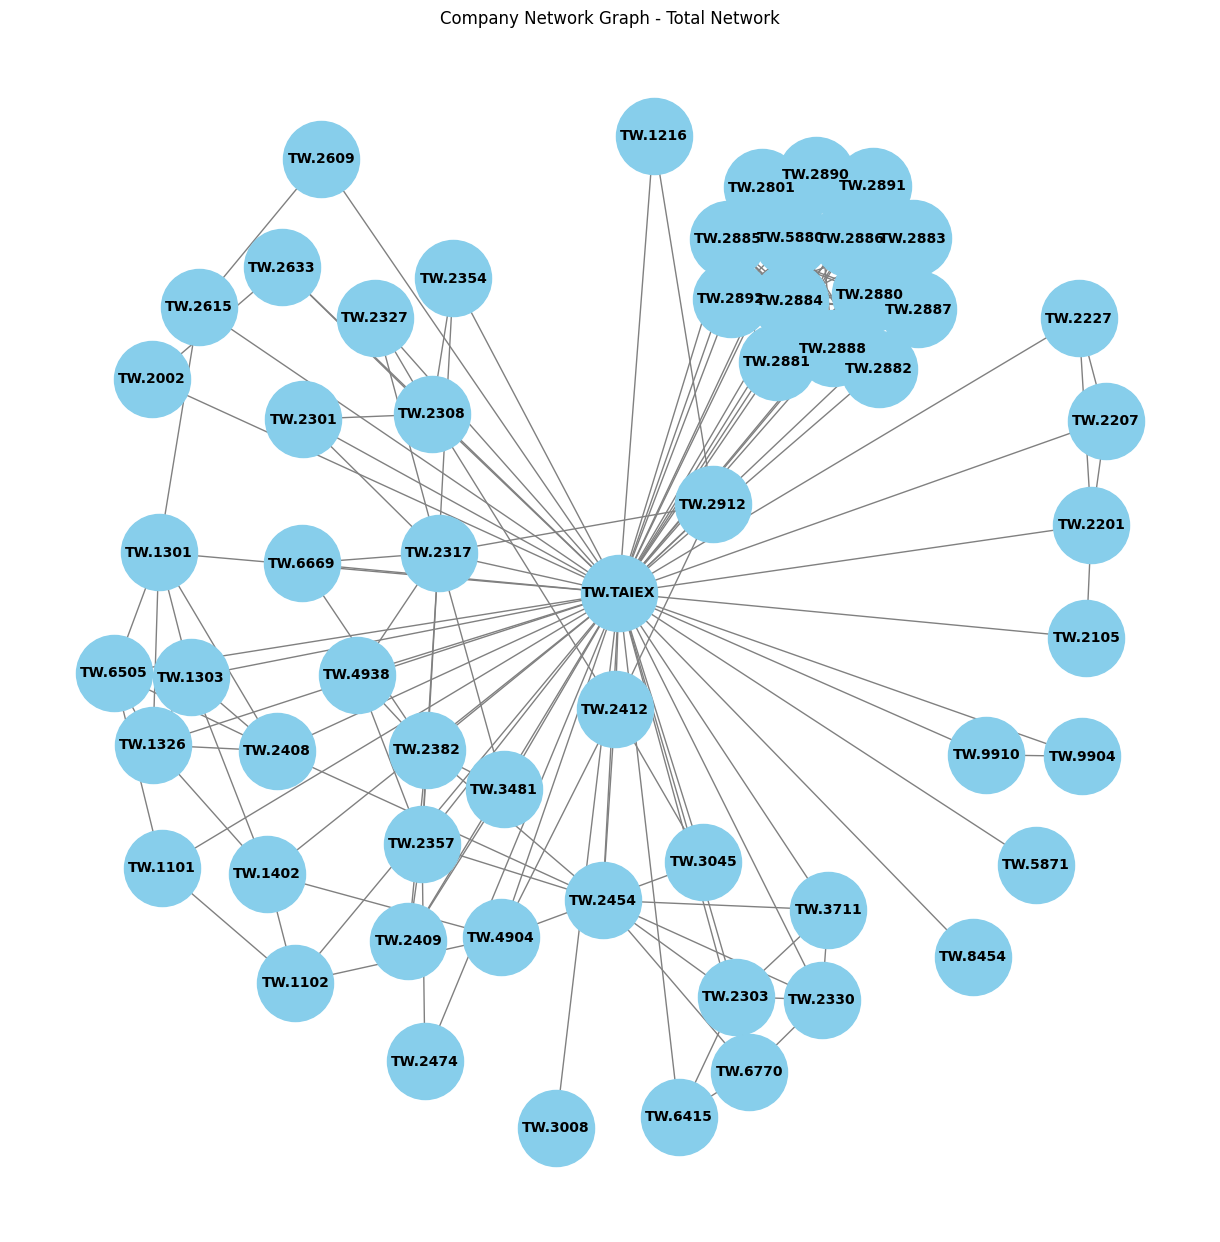

In [ ]:

file_path = './Company_Relationship.xlsx'
data = pd.read_excel(file_path, sheet_name='Total_Network', header = None)

for i in range(data.shape[0]):
  for row_index, j in enumerate(data.iloc[i, 3:].dropna().to_list()):
    numbers = re.findall(r'-?\d+', j)
    if len(numbers) < 2:
        continue
    numbers = [int(num) for num in numbers]
    start, end = numbers[0], numbers[1]
    numbers = f"[{start}, {end}]"
    data.iloc[i, row_index + 3] = numbers

G = nx.Graph()

for index, row in data.iterrows():
    company_name = row[1]
    stock_code = row[2]
    G.add_node(stock_code)

for index, row in data.iterrows():
    company_name = row[1]
    stock_code = row[2]

    connections = row[3:]
    for conn in connections.dropna():
        if isinstance(conn, str):  
            conn = eval(conn)  
        connected_company_index = conn[1]
        connected_company_code = data.iloc[connected_company_index, 2]
        G.add_edge(stock_code, connected_company_code)


plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G) 
nx.draw(G, pos, with_labels=True, node_size=3000, node_color="skyblue", font_size=10, font_weight="bold", edge_color="gray")
plt.title("Company Network Graph - Total Network")
plt.show()


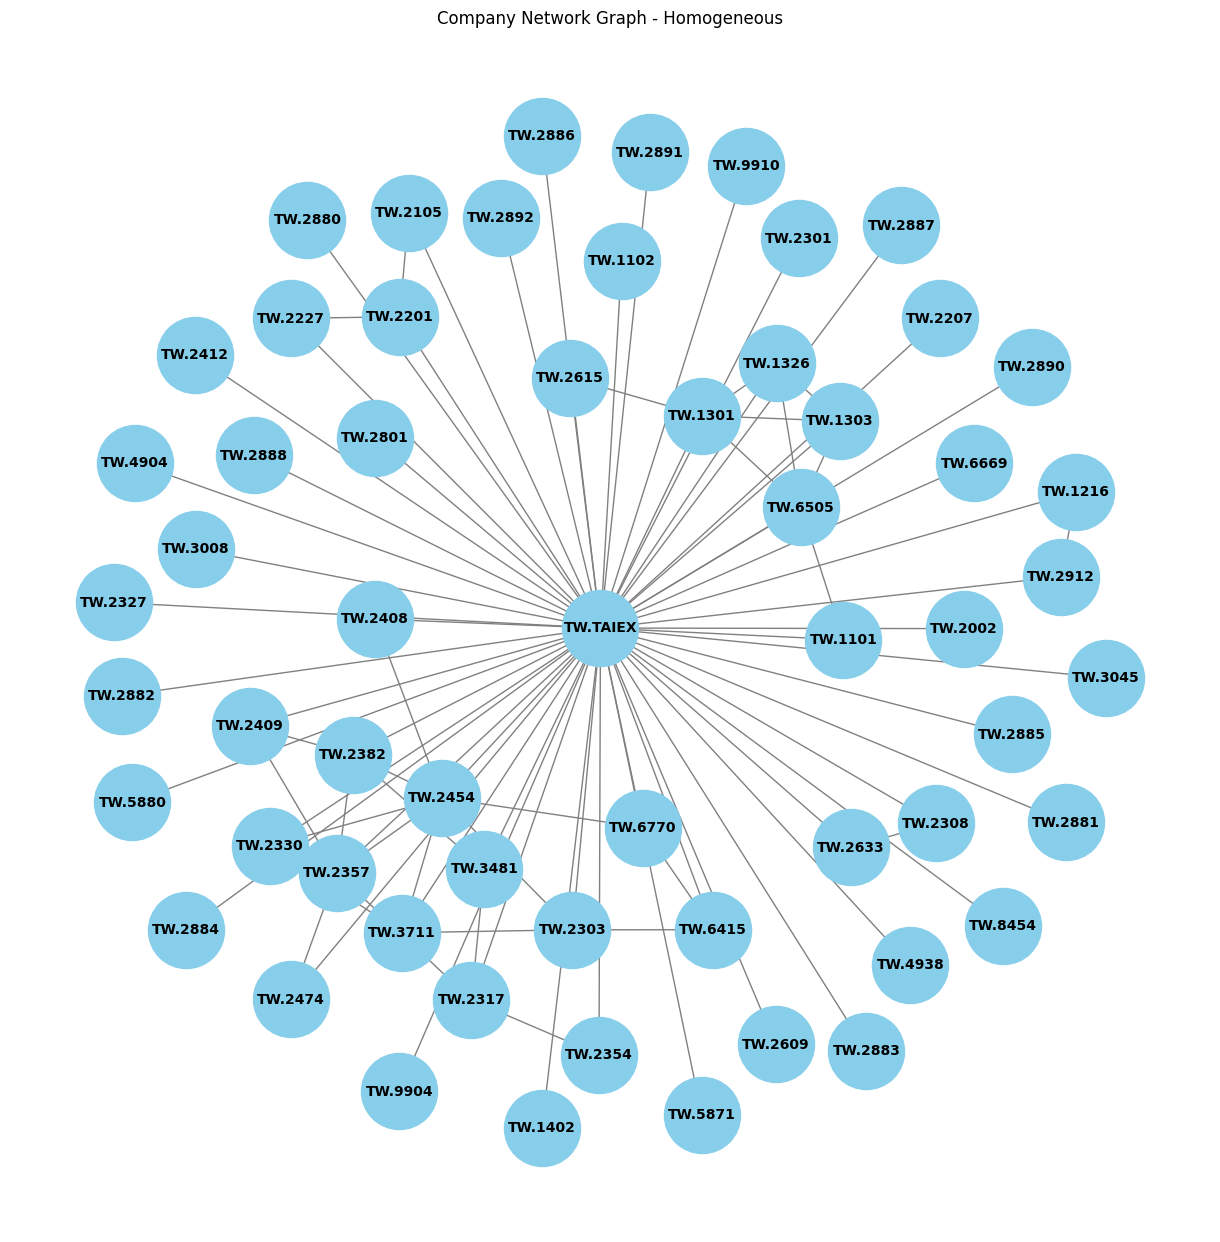

In [ ]:

file_path = './Company_Relationship.xlsx'
data = pd.read_excel(file_path, sheet_name='Homogeneous', header = None)

for i in range(data.shape[0]):
  for row_index, j in enumerate(data.iloc[i, 3:].dropna().to_list()):
    numbers = re.findall(r'-?\d+', j)
    if len(numbers) < 2:
        continue
    numbers = [int(num) for num in numbers]
    start, end = numbers[0], numbers[1]
    numbers = f"[{start}, {end}]"
    data.iloc[i, row_index + 3] = numbers


G = nx.Graph()


for index, row in data.iterrows():
    company_name = row[1]
    stock_code = row[2]
    G.add_node(stock_code)


for index, row in data.iterrows():
    company_name = row[1]
    stock_code = row[2]

    connections = row[3:]
    for conn in connections.dropna():
        if isinstance(conn, str):  
            conn = eval(conn) 
        connected_company_index = conn[1]
        connected_company_code = data.iloc[connected_company_index, 2]
        G.add_edge(stock_code, connected_company_code)


plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G)  
nx.draw(G, pos, with_labels=True, node_size=3000, node_color="skyblue", font_size=10, font_weight="bold", edge_color="gray")
plt.title("Company Network Graph - Homogeneous")
plt.show()


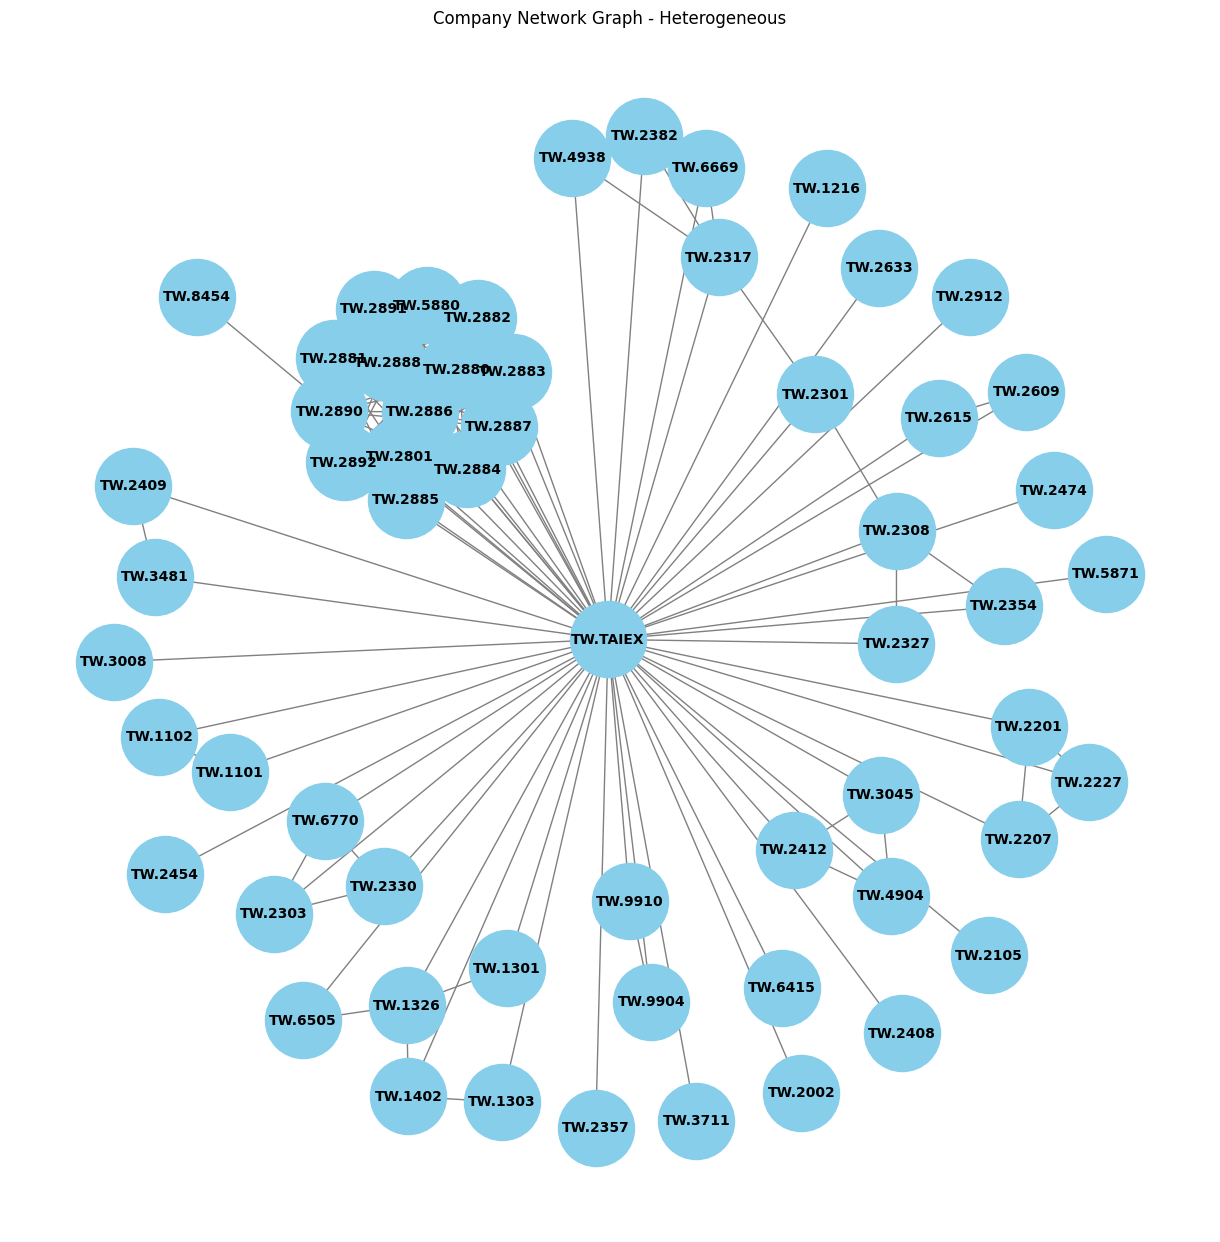

In [ ]:

file_path = './Company_Relationship.xlsx'
data = pd.read_excel(file_path, sheet_name='Heterogeneous', header = None)

for i in range(data.shape[0]):
  for row_index, j in enumerate(data.iloc[i, 3:].dropna().to_list()):
    numbers = re.findall(r'-?\d+', j)
    if len(numbers) < 2:
        continue
    numbers = [int(num) for num in numbers]
    start, end = numbers[0], numbers[1]
    numbers = f"[{start}, {end}]"
    data.iloc[i, row_index + 3] = numbers

G = nx.Graph()

for index, row in data.iterrows():
    company_name = row[1]
    stock_code = row[2]
    G.add_node(stock_code)

for index, row in data.iterrows():
    company_name = row[1]
    stock_code = row[2]

    connections = row[3:]
    for conn in connections.dropna():
        if isinstance(conn, str): 
            conn = eval(conn)  
        connected_company_index = conn[1]
        connected_company_code = data.iloc[connected_company_index, 2]
        G.add_edge(stock_code, connected_company_code)

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G)  
nx.draw(G, pos, with_labels=True, node_size=3000, node_color="skyblue", font_size=10, font_weight="bold", edge_color="gray")
plt.title("Company Network Graph - Heterogeneous")
plt.show()
